# Data Analysis and Predictive Model of House Prices in HCMC, Vietnam.

#### Set up - Import Libraries

In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

#### Functions

In [3]:
def format_price(df):

    price_str = str(df['Price'])

    price_string_split = price_str.split(' ')
    price = 0
    for i in range(len(price_string_split)):
        if price_string_split[i] == 'tỷ':
            price += int(price_string_split[i-1])*1000
        if price_string_split[i] == 'triệu':
            price += int(price_string_split[i-1])
    
    return price

In [4]:
def administrative_division_category(df):
    if 'Quận' in str(df['District']):
        return 'Urban'
    elif 'Huyện' in str(df['District']):
        return 'Suburban'

In [5]:
def living_area_calc(df):
    return df['Ground_Area'] * df['Floor']

## Overview

## 1. Data Wragling
- **1.0** Extract data from property's title 
    - Extract if the property is in frontage or not
    - Extract how many floors is the property
- **1.1** Handle missing values
    - Drop null in column `Floor` and `Price`
- **1.2** Correct data format
    - Correct `Price` format: From Vietnamese expression to numeric format (Unit: million VND)
- **1.3** Data standardization
    - Correct `District` format: From Vietnamese to District Code.
- **1.4** Bin data / Add features to the data.
    - Adding `Division_Type` column which conclude of <ins>Urban</ins> and <ins>Suburban</ins>
    - Adding `Living_Area` column which is total living space, calculated by `Ground_Area` x `Floor`
- **Add-on** Write clean data into `clean_hcmc_house_data.csv` to optimize process of EDA and Model Building

In [ ]:
# Loading into DataFrame

df = pd.read_csv('hcmc_house_data.csv')

# Dropping irrelevant columns
df.drop(columns='Page', axis=1, inplace=True)

df.head()

,Title,Date,District,City,Ground_Area,Bedroom,Restroom,Price
0,nhà 5 tầng Biệt thư City Land nguyễn oanh. pha...,2024-11-06,Quận Gò Vấp,TPHCM,100,5,5,17 tỷ
1,"Bán nhà HXH 128 Thiên Phước , p9 , Q tân bình....",2024-11-06,Quận Tân Bình,TPHCM,50,4,3,10 tỷ 500 triệu
2,Nhà đẹp sổ hồng trệt 2 lầu ở Nhơn Đức Nhà Bè,2024-11-06,Huyện Nhà Bè,TPHCM,25,3,2,1 tỷ 390 triệu
3,Chính Chủ bán Biệt thự mái Thái TP Biên Hòa- M...,2024-11-06,Quận 9 (TP. Thủ Đức),TPHCM,619,3,3,3 tỷ 400 triệu
4,Bán nhà Chính Chủ: Địa chỉ: 293/41/3. Bạch Đằn...,2024-11-06,Quận Bình Thạnh,TPHCM,33,2,2,4 tỷ 350 triệu


In [ ]:
# An overview of DataFrame

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119654 entries, 0 to 119653
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Title        119654 non-null  object
 1   Date         119654 non-null  object
 2   District     119654 non-null  object
 3   City         119654 non-null  object
 4   Ground_Area  119654 non-null  int64 
 5   Bedroom      119654 non-null  int64 
 6   Restroom     119654 non-null  int64 
 7   Price        119652 non-null  object
dtypes: int64(3), object(5)
memory usage: 7.3+ MB


### 1.0 Extract data from property's title

In [ ]:
def frontage(df):
    prop_title = re.sub(r"[,.;@#?!&$]+\ *", " ", df['Title'].lower())
    
    if 'mặt tiền' in prop_title:
        return 1
    elif re.findall('mt', prop_title):
        return 1
    elif re.findall('bt', prop_title):
        return 1
    elif 'biệt thự' in prop_title or 'villa' in prop_title:
        return 1
    else: 
        return 0

In [ ]:
def floor(df):
    prop_title = re.sub(r"[,.;@#?!&$()|-]+\ *", " ", df['Title'].lower())
    prop_title_split = prop_title.lower().split(' ')
    patternL = r"^\d+L$"
    patternT = r"^\d+T$"

    floor = None

    for i, word in enumerate(prop_title_split):
        if word.lower() == 'lầu' and i != 0:
            if prop_title_split[i-1].isnumeric():
                return 1 + int(prop_title_split[i-1])
            else:
                return 2
        elif word.lower() == 'tầng' and i != 0:
            if prop_title_split[i-1].isnumeric():
                return int(prop_title_split[i-1]) 
        elif word.lower() == 'tầng' and i != 0:
            if prop_title_split[i-1].isnumeric():
                return int(prop_title_split[i-1])
        elif word.lower() == 'tấm' and i != 0:
            if prop_title_split[i-1].isnumeric():
                return int(prop_title_split[i-1]) 
        elif word.lower() == '1t1l':
            return 2
        elif word.lower() == '1t2l':
            return 3
        elif re.match(patternL, word):
            word = word[:-1]
            return 1 + int(word)
        elif re.match(patternT, word):
            word = word[:-1]
            return int(word)
        
        if 'biệt thự' in prop_title or 'villa' in prop_title:
            return 3
        elif 'nhà cấp 4' in prop_title:
            return 2
    return floor

In [182]:
floor = df.apply(floor, axis=1)

df['Floor'] = floor

In [183]:
frontage = df.apply(frontage, axis = 1)

df['Frontage'] = frontage 

### 1.1 Handle Missing Values

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119654 entries, 0 to 119653
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Title        119654 non-null  object 
 1   Date         119654 non-null  object 
 2   District     119654 non-null  object 
 3   City         119654 non-null  object 
 4   Ground_Area  119654 non-null  int64  
 5   Bedroom      119654 non-null  int64  
 6   Restroom     119654 non-null  int64  
 7   Price        119652 non-null  object 
 8   Floor        45786 non-null   float64
 9   Frontage     119654 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 9.1+ MB


In [185]:
df.isnull().sum()

Title              0
Date               0
District           0
City               0
Ground_Area        0
Bedroom            0
Restroom           0
Price              2
Floor          73868
Frontage           0
dtype: int64

In [186]:
df = df.dropna()

In [187]:
df.reset_index(drop=True, inplace=True)

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45785 entries, 0 to 45784
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        45785 non-null  object 
 1   Date         45785 non-null  object 
 2   District     45785 non-null  object 
 3   City         45785 non-null  object 
 4   Ground_Area  45785 non-null  int64  
 5   Bedroom      45785 non-null  int64  
 6   Restroom     45785 non-null  int64  
 7   Price        45785 non-null  object 
 8   Floor        45785 non-null  float64
 9   Frontage     45785 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 3.5+ MB


### 1.2 Correct Data Format

In [189]:
df['Price'].head()

0              17 tỷ
1    10 tỷ 500 triệu
2     1 tỷ 390 triệu
3     3 tỷ 400 triệu
4     4 tỷ 950 triệu
Name: Price, dtype: object

The `Price` columns is now in written form in Vietnamese language.   
&rarr; We would want to convert it into numeric form.

In [190]:
formated_price = df.apply(format_price, axis=1)

df['Price'] = formated_price

df.head()

KeyboardInterrupt: 

### 1.3 Data Standardization

In [ ]:
df['District'].value_counts()

District
Quận Tân Bình                 4904
Quận Bình Thạnh               4866
Quận Gò Vấp                   3959
Quận Bình Tân                 3699
Quận Phú Nhuận                2861
Quận Tân Phú                  2748
Quận 7                        2707
Quận 2 (TP. Thủ Đức)          2657
Quận 3                        2538
Quận 1                        2424
Quận 10                       2318
Quận 12                       1831
Quận 9 (TP. Thủ Đức)          1769
Quận Thủ Đức (TP. Thủ Đức)    1749
Quận 6                         995
Quận 11                        755
Quận 8                         736
Huyện Nhà Bè                   645
Quận 5                         609
Quận 4                         453
Huyện Hóc Môn                  360
Huyện Bình Chánh               137
Huyện Củ Chi                    65
Name: count, dtype: int64

Those `District` names are synchronized, but they are in Vietnamese languages and difficult to process.  
&rarr; Standardize these `District` by district code.  

|District|Code|District|Code|District|Code|
|--|--|--|--|--|--|
|Quận 1|D1HCM|Quận 9 (TP. Thủ Đức)|D9TDHCM|Quận Tân Phú|DTANPHUHCM|
|Quận 2 (TP. Thủ Đức)|D2TDHCM|Quận 10|D10HCM|Quận Tân Bình|DTANBINHHCM|
|Quận 3|D3HCM|Quận 11|D11HCM|Quận Bình Tân|DBINHTANHCM|
|Quận 4|D4HCM|Quận 12|D12HCM|Huyện Cần Giờ|SDCANGIOHCM|
|Quận 5|D5HCM|Quận Thủ Đức (TP. Thủ Đức)|DTHUDUCTDHCM|Huyện Hóc Môn|SDHOCMONHCM|
|Quận 6|D6HCM|Quận Phú Nhuận|DPHUNHUANHCM|Huyện Bình Chánh|SDBINHCHANHHCM|
|Quận 7|D7HCM|Quận Gò Vấp|DGOVAPHCM|Huyện Củ Chi|SDCUCHIHCM|
|Quận8|D8HCM|Quận Bình Thạnh|DBINHTHANHHCM|Huyện Nhà Bè|SDNHABEHCM|

In [ ]:
# Mapping District Name to District Code

df['District_Code'] = df['District'].map({'Quận 1': 'D1HCM', 'Quận 2 (TP. Thủ Đức)': 'D2TDHCM',
                                          'Quận 3': 'D3HCM', 'Quận 4': 'D4HCM', 'Quận 5': 'D5HCM',
                                          'Quận 6': 'D6HCM', 'Quận 7': 'D7HCM', 'Quận 8': 'D8HCM',
                                          'Quận 9 (TP. Thủ Đức)': 'D9TDHCM', 'Quận 10': 'D10HCM',
                                          'Quận 11': 'D11HCM', 'Quận 12': 'D12HCM', 
                                          'Quận Thủ Đức (TP. Thủ Đức)': 'DTHUDUCHCM', 
                                          'Quận Phú Nhuận': 'DPHUNHUANHCM', 'Quận Gò Vấp': 'DGOVAPHCM', 
                                          'Quận Bình Thạnh': 'DBINHTHANHHCM', 'Quận Tân Phú':'DTANPHUHCM',
                                          'Quận Tân Bình':'DTANBINHHCM', 'Quận Bình Tân': 'DBINHTANHCM',
                                          'Huyện Cần Giờ': 'SDCANGIOHCM', 'Huyện Hóc Môn': 'SDHOCMONHCM',
                                          'Huyện Bình Chánh': 'SDBINHCHANHHCM', 'Huyện Củ Chi': 'SDCUCHIHCM',
                                          'Huyện Nhà Bè': 'SDNHABEHCM'})

### 1.4 Bin Data/ Add Features. 

There are differences between "Quận" and "Huyện" in Vietnam Administrative Division. Even though they are both `District`, but it still can be divided into "Urban District", which is "Quận", and "Suburban District", which is "Huyện"

In [ ]:
div_type = df.apply(administrative_division_category, axis=1)

df['Division_Type'] = div_type

In [ ]:
living_space = df.apply(living_area_calc, axis=1)

df['Living_Area'] = living_space

### Write clean data to `clean_hcmc_house_data.csv`

In [ ]:
# Drop columns that no longer relevant

df.drop(columns=['Title'], inplace=True)

df.drop(columns=['District'], inplace=True)


In [ ]:
# Rearrange columns in DataFrame

df = df[['Date', 'City', 'District_Code', 'Division_Type', 
        'Frontage',  'Bedroom', 'Restroom', 'Floor',
        'Ground_Area', 'Living_Area', 'Price']]

df.head()

,Date,City,District_Code,Division_Type,Frontage,Bedroom,Restroom,Floor,Ground_Area,Living_Area,Price
0,2024-11-06,TPHCM,DGOVAPHCM,Urban,0,5,5,5.0,100,500.0,17000
1,2024-11-06,TPHCM,DTANBINHHCM,Urban,0,4,3,4.0,50,200.0,10500
2,2024-11-06,TPHCM,SDNHABEHCM,Suburban,0,3,2,3.0,25,75.0,1390
3,2024-11-06,TPHCM,D9TDHCM,Urban,1,3,3,3.0,619,1857.0,3400
4,2024-11-06,TPHCM,DBINHTHANHHCM,Urban,0,3,4,3.0,35,105.0,4950


In [ ]:
df.to_csv('clean_hcmc_house_data.csv', index=False)

## 2. Exploratory Data Analysis
- **2.0** Understanding Data
- **2.1** Handle Outliers
    - Outliers in `Prices`
- **2.2** Descriptive Statistic
- **2.3** Determine Correlation

In [67]:
df = pd.read_csv('clean_hcmc_house_data.csv')

df['Date'] = pd.to_datetime(df['Date'])

In [68]:
df.head()

,Date,City,District_Code,Division_Type,Frontage,Bedroom,Restroom,Floor,Ground_Area,Living_Area,Price
0,2024-11-06,TPHCM,DGOVAPHCM,Urban,0,5,5,5.0,100,500.0,17000
1,2024-11-06,TPHCM,DTANBINHHCM,Urban,0,4,3,4.0,50,200.0,10500
2,2024-11-06,TPHCM,SDNHABEHCM,Suburban,0,3,2,3.0,25,75.0,1390
3,2024-11-06,TPHCM,D9TDHCM,Urban,1,3,3,3.0,619,1857.0,3400
4,2024-11-06,TPHCM,DBINHTHANHHCM,Urban,0,3,4,3.0,35,105.0,4950


### 2.0 Understanding Data

| Columns | Unit | Content |
|-- | -- | --|
| Date | | The date the property posted onto the website|
| City | | City of where the property is |
| District_Code | |Code of district where the property is |
| Division Type | | Administrative Division Type of Vietnam: Urban or Suburban|
| Frontage | | Whether the property is in the frontage or not |
| Bedroom | room | Number of bedroom in the house |
| Restroom | room | Number of restroom in the house |
| Floor | floor | Number of floor in the property |
| Ground_Area | m<sup>2</sup> | Ground area of the house (In meter squared)|
| Living Area| m<sup>2</sup> | Total living area of the house |
| Price | million VND | The price of property on the website (In million Vietnamese Dong) |

### 2.1 Handle Outliers

#### Handle Outliers in `Price`

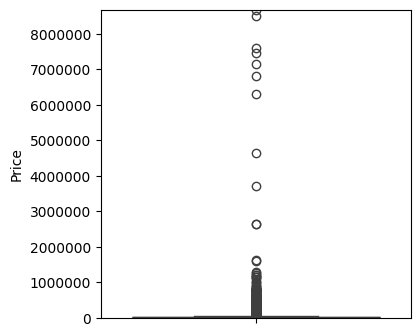

In [76]:
plt.subplots(figsize=(4,4))

sns.boxplot(data=df['Price'])
plt.ylim(df['Price'].min(), df['Price'].max())
plt.ticklabel_format(style='plain', axis='y')

As we can see in the boxplot above, this data is skewed with a lot of outliers due to those 'dirty data' on the website.

In [77]:
print(df['Price'].min())

print(df['Price'].max())

0
8690000


Those number are unreasonable. 

We need to put threshold on the `Price` column to exclude price that are significantly unreasonable.

A house can not be below 500 million VND (`Price` < 500)

In [78]:
df.drop(df[df['Price']<500].index, inplace=True)

Also, we are not interesting in houses that more 5 hundred billion VND (`Price` > 500000)

In [79]:
df.drop(df[df['Price']>100000].index, inplace=True)

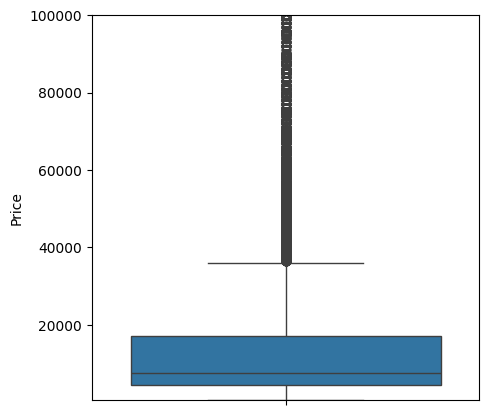

In [80]:
plt.subplots(figsize=(5,5))

sns.boxplot(data=df['Price'])
plt.ylim(df['Price'].min(), df['Price'].max())
plt.ticklabel_format(style='plain', axis='y')

Even though after putting the threshold, the data is still heavily skewed with a lot of outliers.   
&rarr; But is it anomalies or it really reflect the reality of the market? 

In [81]:
# Print out where most of the outliers are

df[(df['Price']>20000)]['District_Code'].value_counts().head()

District_Code
D2TDHCM          1603
D1HCM            1567
D3HCM            1076
DTANBINHHCM      1031
DBINHTHANHHCM     842
Name: count, dtype: int64

We see that even though most of the outliers (higher than one hundread billions VND) are located in D1, D2, D3 and some in Binh Thanh and Phu Nhuan district. These are all <ins>prestigious central neighborhoods</ins> of Ho Chi Minh city, Vietnam. It is reasonable for these areas to have really high real estate value

#### Handle Outliers in `Ground_Area` 

In [56]:
print(df['Ground_Area'].min())
print(df['Ground_Area'].max())

0
75300


These numbers are, also, unreasonable. 

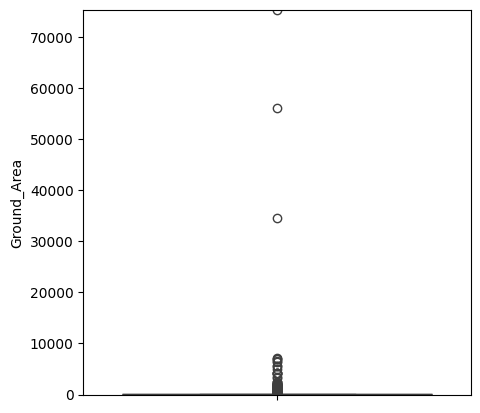

In [57]:
plt.subplots(figsize=(5,5))

sns.boxplot(data=df['Ground_Area'])
plt.ylim(df['Ground_Area'].min(), df['Ground_Area'].max())
plt.ticklabel_format(style='plain', axis='y')

They are only 3 outliers with `Ground_Area` more than 30000m<sup>2</sup> (Which is some kind of unreasonable in a densely populated city like HCMC)   
&rarr; We gonna drop these outliers

In [ ]:
df.drop(df[df['Ground_Area']>30000].index, inplace=True)

In [ ]:
df.drop(df[df['Ground_Area']<=4].index, inplace=True)

### 2.2 Descriptive Statistic

In [60]:
df['Date'].dtypes

df.describe(exclude=['<M8[ns]', object]).round(2)

,Frontage,Bedroom,Restroom,Floor,Ground_Area,Living_Area,Price
count,44288.00,44288.00,44288.00,44288.00,44288.00,44288.00,44288.00
mean,0.40,4.55,4.52,3.60,95.12,356.64,14644.64
std,0.49,4.69,4.74,1.48,132.81,508.52,17887.97
min,0.00,0.00,0.00,1.00,0.00,0.00,500.00
25%,0.00,3.00,2.00,3.00,51.00,144.00,4300.00
50%,0.00,4.00,4.00,3.00,68.00,240.00,7590.00
75%,1.00,5.00,5.00,4.00,100.00,400.00,17000.00
max,1.00,100.00,100.00,81.00,7070.00,28280.00,100000.00


#### House Price in Different Area of HCMC

We can divide the map of HCMC into 4 main areas:
- <ins>Urban District</ins>: D1, D3, D4, D5, D6, D8, D10, D11, Tan Phu, Tan Binh, Go Vap, Binh Thanh and Phu Nhuan
- <ins>Peri-Urban District</ins>: D7, D12 and Binh Tan
- <ins>Thu Duc City</ins>: D2, D9 and Thu Duc
- <ins>Suburban District</ins>: Cu Chi, Hoc Mon, Binh Chanh, Nha Be, Can Gio

In [61]:
urban_district = ['D1HCM', 'D3HCM', 'D4HCM', 'D5HCM', 'D6HCM', 'D8HCM', 'D10HCM', 'D11HCM',
                  'DTANPHUHCM', 'DTANBINHHCM', 'DGOVAPHCM', 'DBINHTHANHHCM', 'DPHUNHUANHCM']

peri_urban_district = ['D7HCM', 'D12HCM', 'DBINHTANHCM']

thuduc_city = ['D2TDHCM', 'D9TDHCM', 'DTHUDUCTDHCM']

suburban_district = ['SDCUCHIHCM', 'SDHOCMONHCM', 'SDBINHCHANHHCM', 'SDNHABEHCM', 'SDCANGIOHCM']

In [62]:
urban_dist_df = df[df['District_Code'].isin(urban_district)]
peri_urban_df = df[df['District_Code'].isin(peri_urban_district)]
thuduc_city_df = df[df['District_Code'].isin(thuduc_city)]
suburban_dist_df = df[df['District_Code'].isin(suburban_district)]

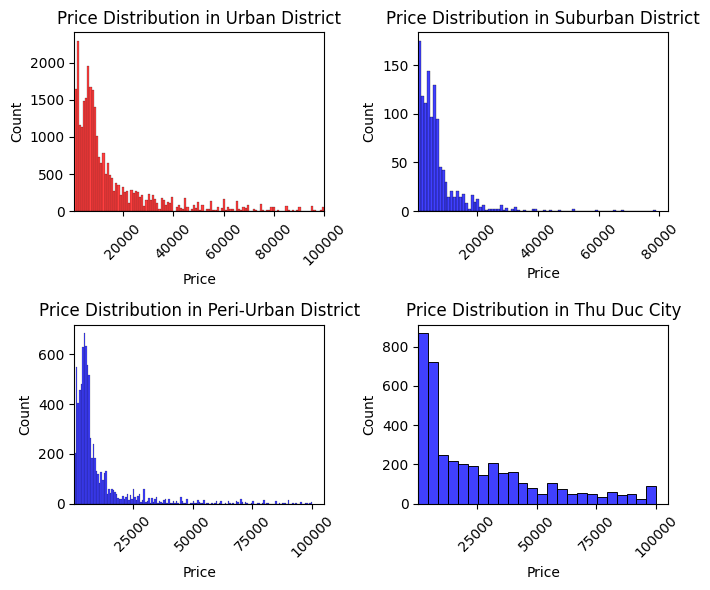

In [63]:
# Ploting Price Distribution in Different Area

figure, ax = plt.subplots(2,2, figsize=(7,6))
plt.ticklabel_format(style='plain', axis='x')

sns.histplot(urban_dist_df['Price'], color='red', ax=ax[0,0])
ax[0,0].set_title('Price Distribution in Urban District')
ax[0,0].set_xlim(left= urban_dist_df['Price'].min(), right=urban_dist_df['Price'].max())
ax[0,0].tick_params(axis='x', rotation=45)

sns.histplot(suburban_dist_df['Price'], color='blue', ax=ax[0,1])
ax[0,1].set_title('Price Distribution in Suburban District')
ax[0,1].set_xlim(left= suburban_dist_df['Price'].min())
ax[0,1].tick_params(axis='x', rotation=45)

sns.histplot(peri_urban_df['Price'], color='blue', ax=ax[1,0])
ax[1,0].set_title('Price Distribution in Peri-Urban District')
ax[1,0].set_xlim(left= peri_urban_df['Price'].min())
ax[1,0].tick_params(axis='x', rotation=45)

sns.histplot(thuduc_city_df['Price'], color='blue', ax=ax[1,1])
ax[1,1].set_title('Price Distribution in Thu Duc City')
ax[1,1].set_xlim(left= thuduc_city_df['Price'].min())
ax[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()

#### House Price in HCMC over time

In [64]:
price_over_time_df = df[['Date', 'Price']]

price_over_time_df = price_over_time_df.resample('M', on='Date')['Price'].mean().reset_index()

C:\Users\aDMIN\AppData\Local\Temp\ipykernel_1396\793063434.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  price_over_time_df = price_over_time_df.resample('M', on='Date')['Price'].mean().reset_index()


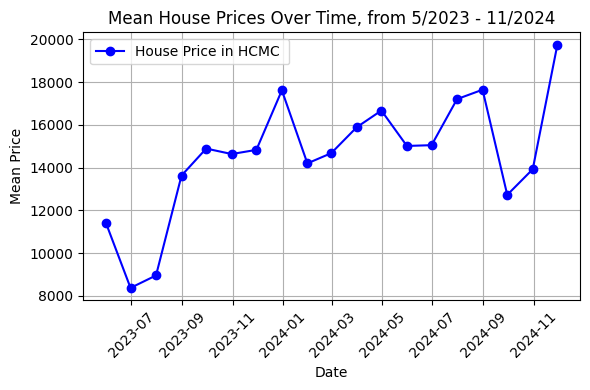

In [65]:
# Plotting the mean house prices over time

plt.figure(figsize=(6, 4))
plt.plot(price_over_time_df['Date'], price_over_time_df['Price'], marker='o', color='b', linestyle='-', 
         label='House Price in HCMC ')
plt.title('Mean House Prices Over Time, from 5/2023 - 11/2024')
plt.xlabel('Date')
plt.ylabel('Mean Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()  # To ensure the plot fits well
plt.show()

### 2.3 Determine Correlations

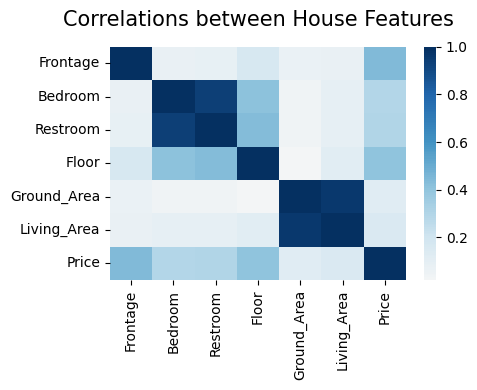

In [20]:
plt.subplots(figsize=(5,4))

sns.heatmap(df.corr(numeric_only=True), cmap='RdBu', center=0)

plt.title('Correlations between House Features', fontsize=15, pad=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout() 
plt.show()

Most of the features have positive correlations with house prices, but it is interesting to note that:
- `Ground_Area` and `Living_Area` exhibits a week correlation with house prices
- `Frontage` is one of the most predictive feature of house price. 

In [31]:
urban_dist_df['Ground_Area']

0        100
1         50
4         35
5         30
6        100
        ... 
45779     72
45780     46
45781     32
45783     40
45784     50
Name: Ground_Area, Length: 29214, dtype: int64

<Axes: ylabel='Ground_Area'>

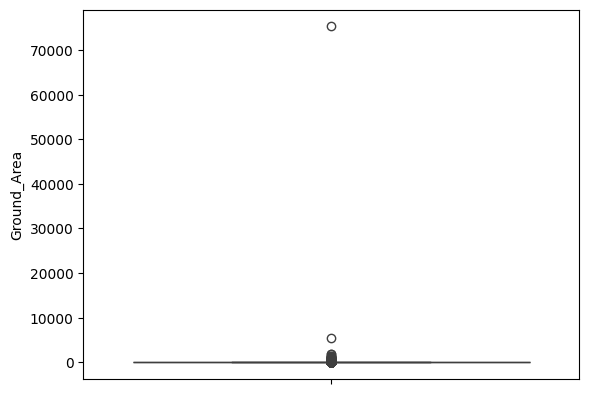

In [47]:
# fig, ax = plt.subplots(1,4,figsize=(8,8))

sns.boxplot(y=urban_dist_df['Ground_Area'])